In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [1]:
# export
from fastai.basic_train import LearnerCallback

In [2]:
# export
from fastai.callbacks.general_sched import *
from fastai.callback import *

In [3]:
# export
from fastai.core import *

In [4]:
# export
from IPython.core import debugger as idb

In [5]:
# export
from torch.utils.tensorboard import SummaryWriter

In [6]:
# export
from FLAI.detect_symbol.exp import optimizer
from FLAI.detect_symbol.exp import tensorboard_callback
from FLAI.detect_symbol.exp import scheduling_train

In [7]:
# export
import sys
if '..' not in sys.path:
    sys.path.append('..')
from exp import resnet_unet
from exp import loss_metrics
from exp import databunch

In [8]:
# export
import torch

In [9]:
# export
from torch import tensor

In [10]:
# export
from torch import nn

In [11]:
# export
from torch.nn import Sequential, ModuleList

In [12]:
# export
from fastai.basic_train import Learner

In [13]:
# export
from fastai.torch_core import bn_types,bias_types

In [14]:
# export
from functools import partial

In [15]:
# export
import os,shutil

In [16]:
# export
from fastai.callbacks import CSVLogger

In [17]:
# export
from fastai.callbacks.tracker import SaveModelCallback

# functions

In [13]:
# export
def txt_write(fh, i, opt, lr, path, csv_fname):
    fh.write('===================================\n')
    fh.write(f'run_{i}\n')
    fh.write('-----------------------------------\n')
    fh.write(f'--opt_func: {opt}\n')
    fh.write(f'--lr: {lr}\n')
    fh.write(f'--csv_log: {path}/{csv_fname}.csv\n')
    fh.write(f'--best model: {path}/models/run_{i}.pth\n')

In [14]:
# export
def multi_train(get_learn, epoch_len, epochs, opts, lrs, checkpoints, tb_log_root,autoSave=True, worseN_th = 5):
    '''
    可以从checkpoint继续训练，为了保证训练连续性，需要手动设置lr与checkpoint保存时一致。
    '''
    # 清理tensorboard log dir
    if os.path.exists(tb_log_root): shutil.rmtree(tb_log_root)
    os.mkdir(tb_log_root)
    
    if not os.path.exists('./run_log/'): os.mkdir('./run_log/')
    txtlog = open('./run_log/log.txt',mode='w')
    for i,(opt,lr,checkpoint) in enumerate(zip(opts,lrs,checkpoints)):
        # create a learner
        learn = get_learn()
        
        # set optimizer
        learn.opt_func = opt
        
        # load checkpoint
        if checkpoint is not None:
            with open(checkpoint,'rb') as f:
                learn.load(f)
        
        # 在txt log中记录
        csv_log_dir = f'csv_log/'
        if not os.path.exists(learn.path/csv_log_dir): os.mkdir(learn.path/csv_log_dir)
        csv_fname = csv_log_dir+f'run_{i}'
        txt_write(txtlog,i,opt,lr,learn.path,csv_fname)
        
        callbacks = []
        # get csvlogger callback
        csvLog = CSVLogger(learn,filename=csv_fname)
        callbacks += [csvLog]
        
        if autoSave:
            # savemodel callback
            autoSave = SaveModelCallback(learn,monitor='valid_loss',mode='min',every='improvement',name=f'run_{i}')
            callbacks += [autoSave]
        
        # get tensorboard callback
        tbCb = get_tbCb(learn,tb_log_root+f'run_{i}')
        callbacks += [tbCb]
        
        # train
        fit(learn=learn, epoch_len=epoch_len, epochs=epochs, lr=lr, callbacks=callbacks, worseN_th = worseN_th)
        
    txtlog.close()

In [17]:
# export
def get_tbCb(learn,log_dir):
    tbCb = tensorboard_callback.TensorBoardCallback(
                                   learn=learn,
                                   log_dir=log_dir,
                                   plot_net=False,
                                   plot_loss=True,
                                   metric_plots=['mask_iou'],
                                   hyper_plots=['lr'],
                                   hist_plots=['down_blocks.2.0.conv1.weight',
                                               'up_blocks.2.conv1.conv.weight'],
                                   hist_iters=50)
    return tbCb

In [18]:
# export
def fit(learn,epoch_len,epochs,lr,callbacks, worseN_th = 5):
    scheduling_train.fit_with_warmup_multiAnnealPlat(learn,
                                    epoch_len=epoch_len,
                                    num_epoch=epochs,

                                    lr_start=lr/10,
                                    lr_constant=lr,
                                    warmup_iter=10,

                                    monitor='train_smooth',
                                    worseN_thres=worseN_th,
                                    annealRate=10,
                                    duration_thres=30,
                                    annealIte=10,
                                    phaseMaxN=3,
                                    finetune_stop=1,
                                    callbacks=callbacks)

# test

In [19]:
# export
# 设置device
device = torch.device('cuda')

In [22]:
# export
ds = './data/dataset_20200715'
data = databunch.get_databunch(ds, bs=16, device=device) 

In [23]:
# export
opts = [partial(optimizer.Adam, betas=(0.9,0.99))]

lrs = [1e-3]

checkpoints = [None]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


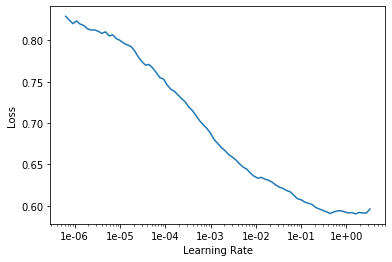

In [24]:
learn = get_learn(data)
learn.opt_func = partial(optimizer.Adam, betas=(0.9,0.99))

learn.lr_find()
learn.recorder.plot()

In [25]:
multi_train(get_learn=partial(resnet_unet.get_learn,data=data), 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.637225,0.686979,0.733969,0.686979,0.295283,00:30
1,0.584005,0.658344,0.724731,0.658344,0.292910,00:30
2,0.558554,0.593374,0.683038,0.593374,0.367078,00:30
3,0.541633,0.528907,0.624395,0.528907,0.360305,00:31
4,0.524296,0.487569,0.598474,0.487569,0.397460,00:31
5,0.507095,0.458037,0.553677,0.458037,0.426135,00:31
6,0.478728,0.414223,0.529840,0.414223,0.543120,00:30
7,0.444471,0.770592,0.682607,0.770592,0.174923,00:31
8,0.415729,0.358769,0.462537,0.358769,0.541597,00:30
9,0.386293,0.954995,0.593670,0.954995,0.251700,00:31


Better model found at epoch 0 with valid_loss value: 0.6869791746139526.
Better model found at epoch 1 with valid_loss value: 0.6583436131477356.
Better model found at epoch 2 with valid_loss value: 0.5933743715286255.
Better model found at epoch 3 with valid_loss value: 0.5289066433906555.
Better model found at epoch 4 with valid_loss value: 0.48756909370422363.
Better model found at epoch 5 with valid_loss value: 0.45803719758987427.
Better model found at epoch 6 with valid_loss value: 0.4142228662967682.
Better model found at epoch 8 with valid_loss value: 0.35876917839050293.
Better model found at epoch 12 with valid_loss value: 0.34162041544914246.
Better model found at epoch 13 with valid_loss value: 0.23886704444885254.
Better model found at epoch 15 with valid_loss value: 0.21325120329856873.
Better model found at epoch 17 with valid_loss value: 0.21101875603199005.
Better model found at epoch 19 with valid_loss value: 0.19111721217632294.
Better model found at epoch 20 with va

KeyboardInterrupt: 

In [27]:

multi_train(get_learn=partial(resnet_unet.get_learn,data=data), 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.559014,0.696392,0.716869,0.696392,0.000000,00:36
1,0.506591,0.663716,0.696999,0.663716,0.326093,00:31
2,0.484401,0.613259,0.664939,0.613259,0.385476,00:30
3,0.463973,0.537986,0.605159,0.537986,0.399828,00:31
4,0.439107,0.459481,0.538257,0.459481,0.469730,00:31
5,0.412740,0.410764,0.482823,0.410764,0.442997,00:31
6,0.376710,0.264881,0.315373,0.264881,0.708487,00:30
7,0.346964,0.288355,0.329674,0.288355,0.593468,00:31
8,0.317036,0.269857,0.285794,0.269857,0.684629,00:31
9,0.287659,0.190840,0.189843,0.190840,0.735000,00:31


Better model found at epoch 0 with valid_loss value: 0.6963922381401062.
Better model found at epoch 1 with valid_loss value: 0.663715660572052.
Better model found at epoch 2 with valid_loss value: 0.613258957862854.
Better model found at epoch 3 with valid_loss value: 0.5379860997200012.
Better model found at epoch 4 with valid_loss value: 0.45948106050491333.
Better model found at epoch 5 with valid_loss value: 0.4107644557952881.
Better model found at epoch 6 with valid_loss value: 0.26488083600997925.
Better model found at epoch 9 with valid_loss value: 0.1908400058746338.
Better model found at epoch 13 with valid_loss value: 0.1696300208568573.
Better model found at epoch 14 with valid_loss value: 0.16637985408306122.
Better model found at epoch 15 with valid_loss value: 0.15656128525733948.
Better model found at epoch 16 with valid_loss value: 0.11723385006189346.
Better model found at epoch 25 with valid_loss value: 0.1056334599852562.
Better model found at epoch 30 with valid_l

# export

In [21]:
!python ../notebook2script.py --fname 'train_script_logger.ipynb' --outputDir '../'

Converted train_script_logger.ipynb to ../train_script_logger.py
